# Inversion with a corrected shapefile for Nordic Glacier

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

import oggm
import os
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import inversion
cfg.initialize(logging_level='WORKFLOW')

2020-06-04 13:46:05: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/params.cfg
2020-06-04 13:46:05: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-06-04 13:46:05: oggm.cfg: Multiprocessing: using all available processors (N=8)


Let's read a file from the standard RGI:

In [3]:
utils.get_rgi_dir(version='61')

'/home/pelto/OGGM/rgi/RGIV61'

In [4]:
sh = utils.get_rgi_region_file('13', version='61')
sh

'/home/pelto/OGGM/rgi/RGIV61/13_rgi61_CentralAsia/13_rgi61_CentralAsia.shp'

Shapefiles are best read an manipulated with [geopandas](http://geopandas.org/) in python (see also oggm [working_with_rgi.ipynb](working_with_rgi.ipynb) tutorial):

In [5]:
gdf = gpd.read_file(sh)
gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-13.00001,G079494E34471N,20000810,-9999999,79.4939,34.4713,13,5,0.432,5678,...,683,0,0,0,0,9,9,None,None,"POLYGON ((79.49945 34.47555, 79.49880 34.47498..."
1,RGI60-13.00002,G077951E35545N,20020802,-9999999,77.9513,35.5452,13,5,0.367,5889,...,1307,0,0,0,0,9,9,None,None,"POLYGON ((77.95519 35.55007, 77.95517 35.54953..."
2,RGI60-13.00003,G077930E35519N,20020802,-9999999,77.9295,35.5188,13,5,0.070,5646,...,426,0,0,0,0,9,9,None,None,"POLYGON ((77.92863 35.52057, 77.92864 35.52030..."
3,RGI60-13.00004,G077924E35525N,20020802,-9999999,77.9237,35.5252,13,5,0.255,5698,...,605,0,0,0,0,9,9,None,None,"POLYGON ((77.91713 35.52720, 77.91764 35.52719..."
4,RGI60-13.00005,G077914E35531N,20020802,-9999999,77.9141,35.5309,13,5,0.261,5644,...,389,0,0,0,0,9,9,None,None,"POLYGON ((77.91939 35.52980, 77.91938 35.52958..."


## Get the RGI geometry and plot it

In [6]:
gl='RGI60-13.52594'
rgidf = utils.get_rgi_glacier_entities([gl])
rgidf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
52591,RGI60-13.52594,G080036E34291N,20110805,-9999999,80.036,34.291,13,8,23.097,5435,...,134,11760,0,0,1,0,9,9,CN5Z421I0054 Zhanjin Glacier,"POLYGON ((80.02679 34.32982, 80.02684 34.32980..."


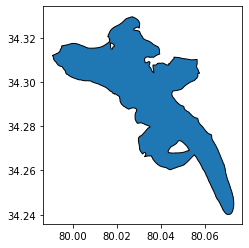

In [7]:
# OGGM set-up
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='RGI_13_trial', reset=True)

# Get the geometry and plot it
# gl = utils.get_rgi_glacier_entities(['RGI60-13.00'], version='61') ##unless I put the version here it doesn't call V61
rgidf.plot(edgecolor='k');

In [8]:
gdirs = workflow.init_glacier_directories(rgidf) #,from_prepro_level=1, prepro_border=10) 
workflow.execute_entity_task(tasks.define_glacier_region, gdirs)
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)

2020-06-04 13:46:19: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-06-04 13:46:21: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-06-04 13:46:22: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
2020-06-04 13:46:23: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2020-06-04 13:46:24: oggm.workflow: Execute entity task catchment_width_correction on 1 g

In [9]:
rgidf.RGIId.values

array(['RGI60-13.52594'], dtype=object)

In [10]:
# from rgitools.funcs import compute_intersects
# new_intersects = compute_intersects(gl)
# new_intersects
divides= utils.get_rgi_intersects_entities([gl])

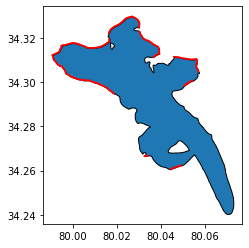

In [11]:
f, ax = plt.subplots()
rgidf.plot(ax=ax, edgecolor='k');  #for_intersects
divides.plot(ax=ax, edgecolor='r');  

In [12]:
gdir=gdirs[0]

In [13]:
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

### calculate the length in meters of the divides plotted in red above

In [16]:
shape=gdir.read_shapefile('intersects')
#     len(shape.geometry)
ds_new['divides_len']=shape.geometry.length

In [15]:
shape

,RGIId_1,RGIId_2,min_x,max_x,min_y,max_y,geometry
0,RGI60-13.52589,RGI60-13.52594,-4178.261806,-1582.388811,3.794838e+06,3.796791e+06,"LINESTRING (-4178.262 3796790.794, -4169.071 3..."
1,RGI60-13.52593,RGI60-13.52594,-347.775523,-162.668086,3.791703e+06,3.791739e+06,"LINESTRING (-347.776 3791702.737, -345.728 379..."
2,RGI60-13.52594,RGI60-13.52595,29.685256,297.439355,3.796691e+06,3.796871e+06,"LINESTRING (294.956 3796871.224, 297.439 37968..."
3,RGI60-13.52594,RGI60-13.52589,-4169.071378,-1585.868390,3.794848e+06,3.796792e+06,"LINESTRING (-1591.287 3794864.811, -1585.868 3..."
4,RGI60-13.52594,RGI60-13.52609,1303.832237,1697.370107,3.795211e+06,3.795509e+06,"LINESTRING (1697.370 3795508.861, 1688.872 379..."
5,RGI60-13.52594,RGI60-13.52609,1827.243298,1943.640691,3.795926e+06,3.796584e+06,"LINESTRING (1830.580 3796582.760, 1840.798 379..."
6,RGI60-13.52594,RGI60-13.52593,-339.519930,-161.587891,3.791708e+06,3.791741e+06,"LINESTRING (-161.588 3791741.128, -178.504 379..."
7,RGI60-13.52594,RGI60-13.52600,753.712337,1215.382870,3.791054e+06,3.791248e+06,"LINESTRING (1215.383 3791247.776, 1206.703 379..."
8,RGI60-13.52594,RGI60-13.53522,-855.525793,-538.542660,3.798163e+06,3.798727e+06,"LINESTRING (-855.526 3798721.669, -846.239 379..."
9,RGI60-13.52594,RGI60-13.53522,-540.017538,297.439355,3.796856e+06,3.797979e+06,"LINESTRING (-540.018 3797979.386, -536.675 379..."


### calculate the length in meters of the outlined plotted in black above

In [17]:
shape=gdir.read_shapefile('outlines')
#     len(shape.geometry)
ds_new['perimeter']=shape.geometry.length[0]

In [19]:
ds_new.perimeter, ds_new.divides_len.sum()

(<xarray.DataArray 'perimeter' ()>
 array(38652.19334194),
 <xarray.DataArray 'divides_len' ()>
 array(26657.7669086))